In [1]:
import os
import pandas as pd
from pathlib import Path
from datasets import load_dataset, DownloadMode, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
destination_path = '\Data'

dataset_emotion = load_dataset(
    "dair-ai/emotion", "unsplit", 
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS
)

print(dataset_emotion)

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\klykk\AppData\Local\Temp\ipykernel_3740\3360832544.py:1: SyntaxWarning: invalid escape sequence '\D'
  destination_path = '\Data'


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 416809
    })
})


In [3]:
# Get class names from dataset features
class_names = dataset_emotion['train'].features['label'].names

# Add new column mapping numeric labels to class names using Dataset.map
dataset_emotion['train'] = dataset_emotion['train'].map(
    lambda example: {'label_name': class_names[example['label']]}
)

# Konverter det fulde datasæt til en pandas DataFrame
df_samlet = dataset_emotion['train'].to_pandas()

print(df_samlet.head())
# Kontroller for manglende værdier
missing_values = df_samlet.isnull().sum()
print('Number of missing values in df_samlet:')
print(missing_values)


                                                text  label label_name
0  i feel awful about it too because it s my job ...      0    sadness
1                              im alone i feel awful      0    sadness
2  ive probably mentioned this before but i reall...      1        joy
3           i was feeling a little low few days back      0    sadness
4  i beleive that i am much more sensitive to oth...      2       love
Number of missing values in df_samlet:
text          0
label         0
label_name    0
dtype: int64


Text lengths

0    112
1     21
2    152
3     40
4     99
Name: text_length, dtype: int64
Minimum text length: 2
Maximum text length: 830
Average text length: 97.02839669968739


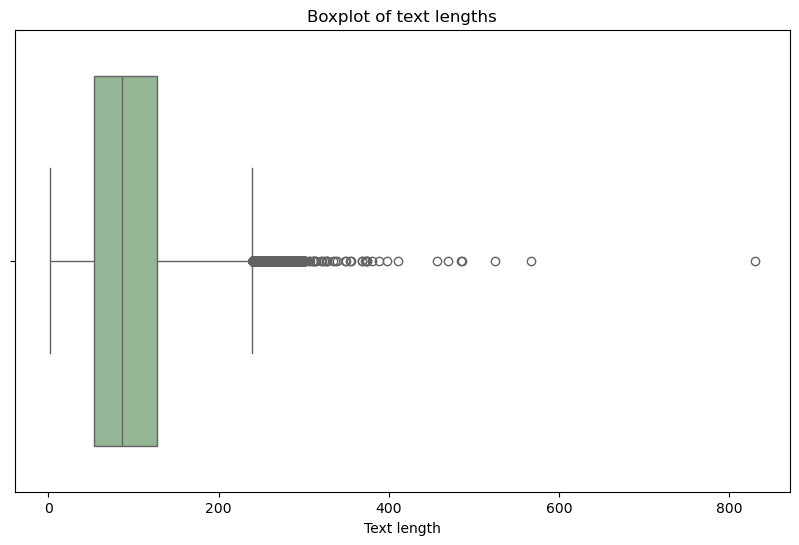

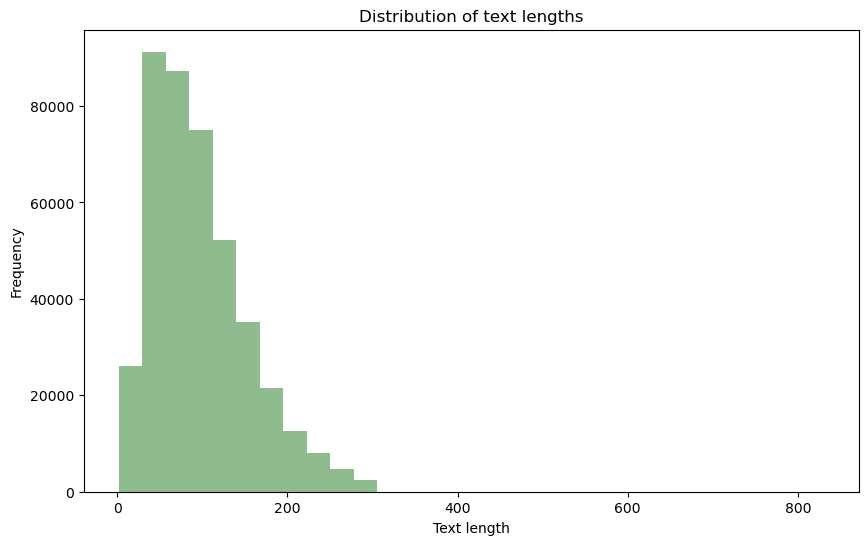

In [4]:
df_samlet['text_length'] = df_samlet['text'].apply(len)

print(df_samlet['text_length'].head())
print(f'Minimum text length: {df_samlet['text_length'].min()}')
print(f'Maximum text length: {df_samlet['text_length'].max()}')
print(f'Average text length: {df_samlet['text_length'].mean()}')

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_samlet['text_length'], color='darkseagreen')
plt.title('Boxplot of text lengths')
plt.xlabel('Text length')
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(df_samlet['text_length'], bins=30, color='darkseagreen')
plt.title('Distribution of text lengths')
plt.xlabel('Text length')
plt.ylabel('Frequency')
plt.show()

Q1: 54.0, Q3: 128.0, IQR: 74.0, Upper whisker: 239.0
Maximum non-outlier text length: 239


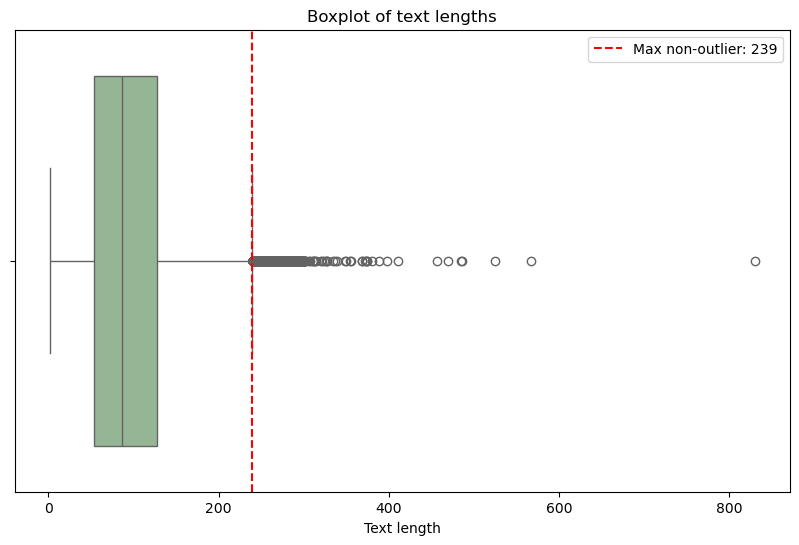

In [5]:
# Beregn Q1 (25. percentil), Q3 (75. percentil) og IQR
q1 = np.percentile(df_samlet['text_length'], 25)
q3 = np.percentile(df_samlet['text_length'], 75)
iqr = q3 - q1

# Beregn max-værdien (øverste grænse for ikke-outliers)
upper_whisker = q3 + 1.5 * iqr

print(f"Q1: {q1}, Q3: {q3}, IQR: {iqr}, Upper whisker: {upper_whisker}")


max_non_outlier = df_samlet['text_length'][df_samlet['text_length'] <= upper_whisker].max()
print(f"Maximum non-outlier text length: {max_non_outlier}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_samlet['text_length'], color='darkseagreen')
plt.title('Boxplot of text lengths')
plt.xlabel('Text length')

# Marker maximum non-outlier værdi
plt.axvline(max_non_outlier, color='red', linestyle='--', label=f'Max non-outlier: {max_non_outlier}')
plt.legend()
plt.show()


In [6]:
# Largest outlier
largest_outlier = df_samlet['text_length'][df_samlet['text_length'] > upper_whisker].max()
print(largest_outlier)

830


In [7]:
number_outliers = df_samlet['text_length'][df_samlet['text_length'] > upper_whisker].count()
print(f"Number of outliers: {number_outliers}")

Number of outliers: 9962


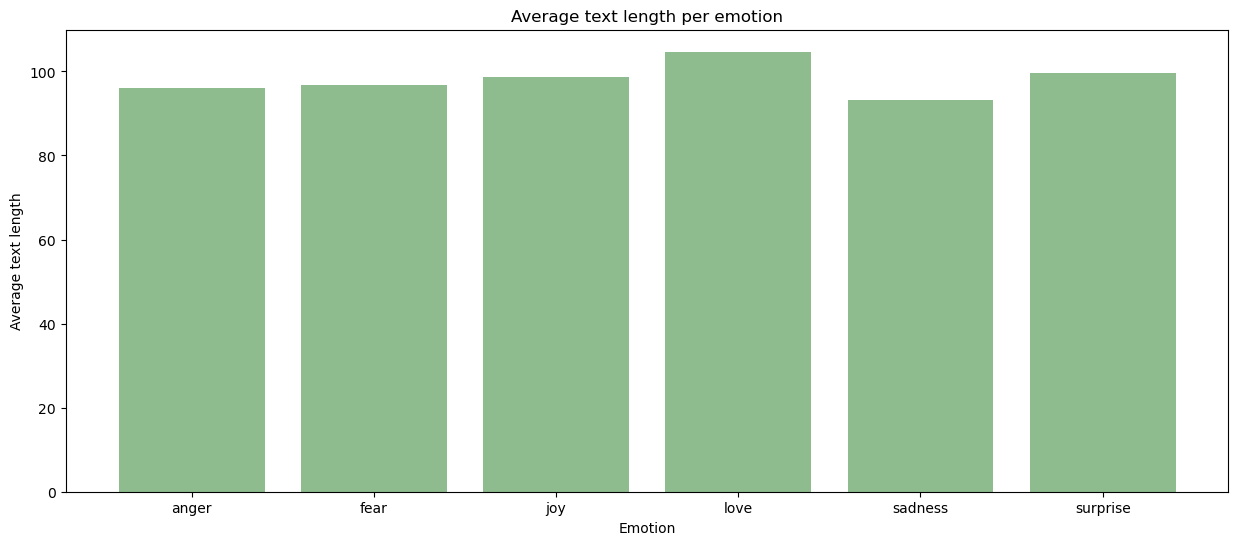

In [8]:
groups_mean_length = df_samlet.groupby('label_name')['text_length'].mean()

plt.figure(figsize=(15, 6))
plt.bar(groups_mean_length.index,groups_mean_length.values, color='darkseagreen')
plt.title('Average text length per emotion')
plt.xlabel('Emotion')
plt.ylabel('Average text length')
plt.show()

In [9]:
outliers= df_samlet[df_samlet['text_length'] > upper_whisker]

print(len(outliers))
print(outliers.head())

9962
                                                  text  label label_name  \
40   i feel doubtful about my place in the world of...      4       fear   
69   i actually think i am a fairly authentic perso...      0    sadness   
101  i try not to be too dismissive of elections si...      1        joy   
218  i feel it s just really boring if you were to ...      0    sadness   
289  i forgive myself for accepting and allowing my...      2       love   

     text_length  
40           292  
69           265  
101          243  
218          275  
289          269  


Distribution of emotions

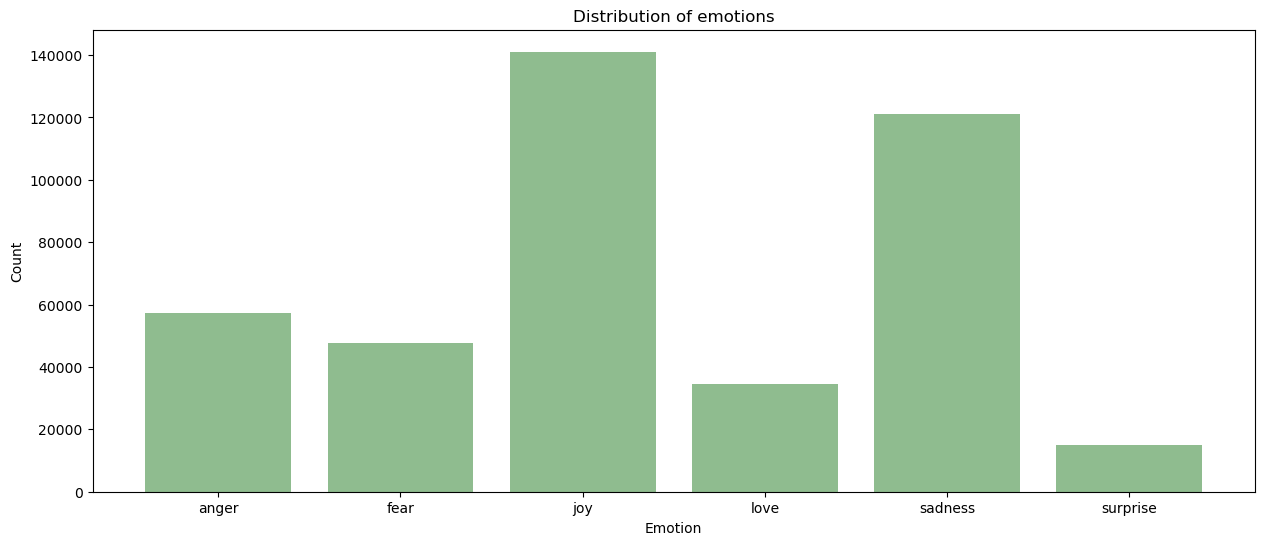

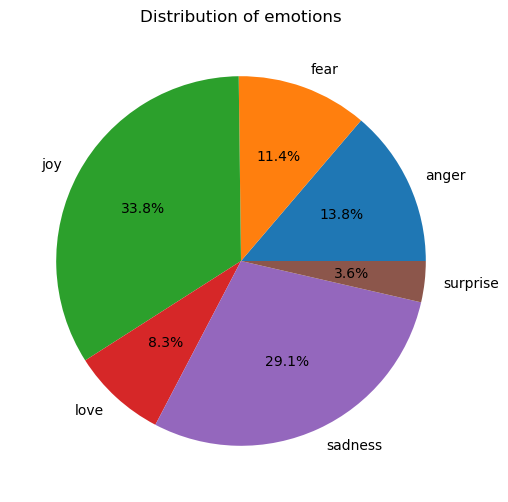

In [10]:
groups = df_samlet.groupby('label_name')['text'].count()

plt.figure(figsize=(15, 6))
plt.bar(groups.index,groups.values, color='darkseagreen')
plt.title('Distribution of emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()


plt.figure(figsize=(15, 6))
plt.pie(groups.values, labels=list(groups.index),autopct='%1.1f%%')
plt.title('Distribution of emotions')
plt.show()

Distributions of emotions for outliers

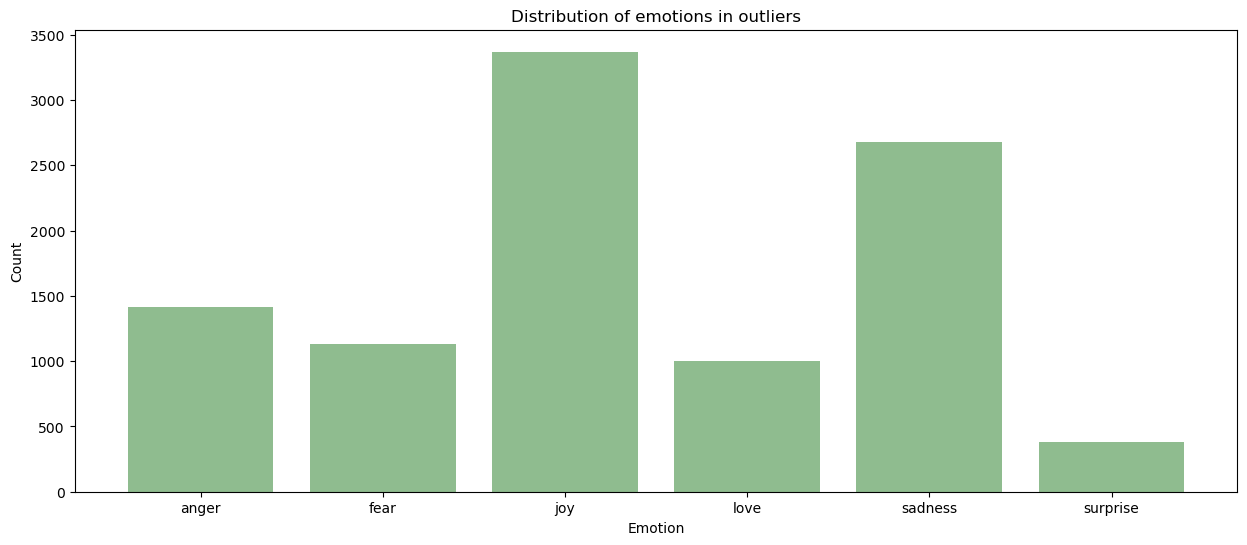

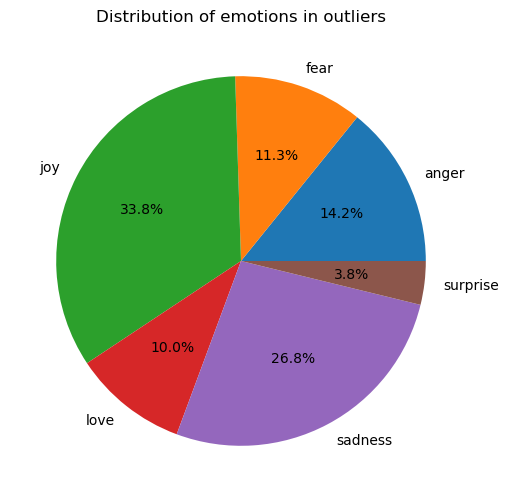

In [11]:
groups_outliers = outliers.groupby('label_name')['text'].count()

plt.figure(figsize=(15, 6))
plt.bar(groups_outliers.index,groups_outliers.values, color='darkseagreen')
plt.title('Distribution of emotions in outliers')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()


plt.figure(figsize=(15, 6))
plt.pie(groups_outliers.values, labels=list(groups_outliers.index),autopct='%1.1f%%')
plt.title('Distribution of emotions in outliers')
plt.show()

Word frequencies before lemmatization and removing stopwords

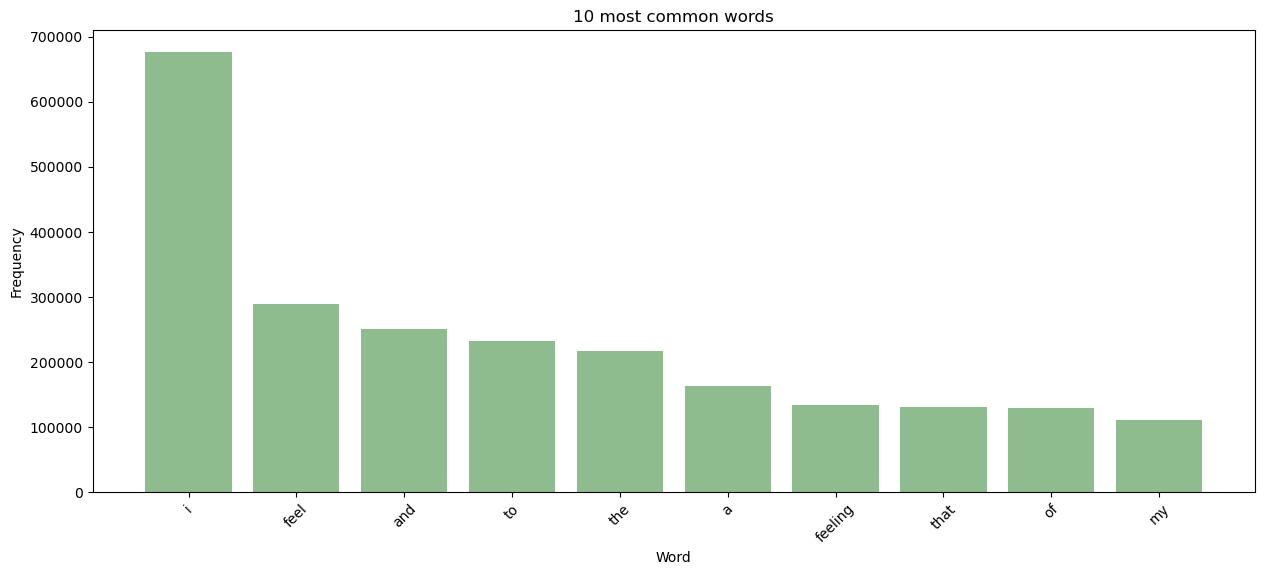

In [12]:
def word_freq(text):
    # Find words and count their frequencies
    words = re.findall(r'\b\w+\b', text)
    word_counts = Counter(words)

    return word_counts

df_samlet['word_freq'] = df_samlet['text'].apply(word_freq)

all_word_counts = Counter()
for freq in df_samlet['word_freq']:
    all_word_counts.update(freq)

most_common_words = all_word_counts.most_common(10)
words = [word for word, _ in most_common_words]
freqs = [count for _, count in most_common_words]


plt.figure(figsize=(15, 6))
plt.bar(words, freqs, color='darkseagreen')
plt.title('10 most common words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Word frequencies before lemmatization and removing stopwords in outliers

C:\Users\klykk\AppData\Local\Temp\ipykernel_3740\309216951.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['word_freq'] = outliers['text'].apply(word_freq)


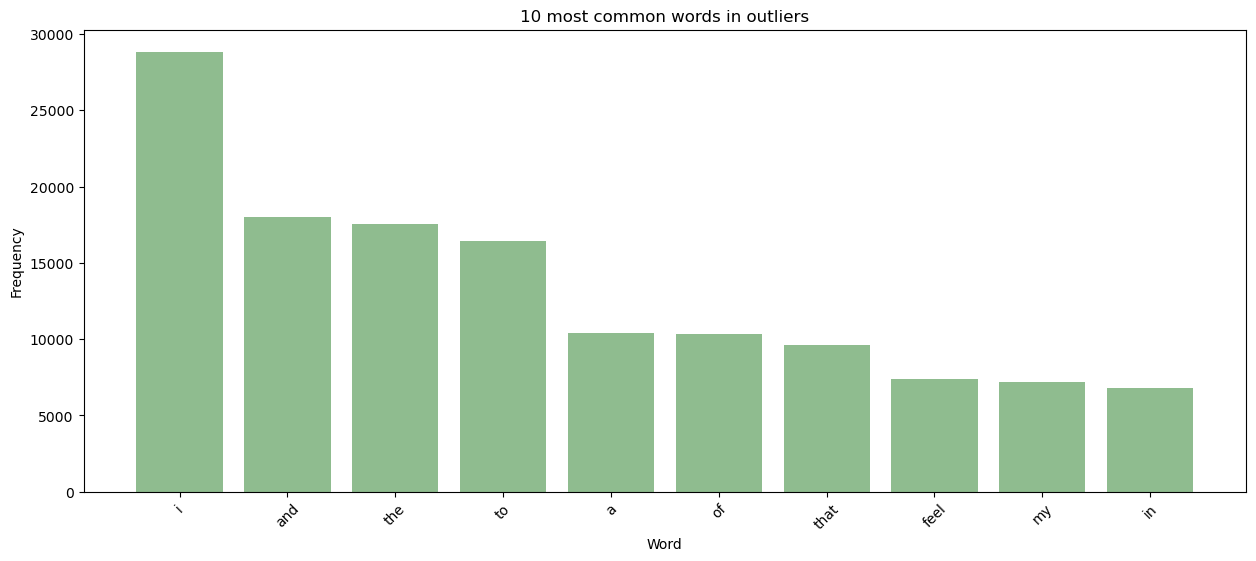

In [13]:
def word_freq(text):
    # Find words and count their frequencies
    words = re.findall(r'\b\w+\b', text)
    word_counts = Counter(words)

    return word_counts

outliers['word_freq'] = outliers['text'].apply(word_freq)

all_word_counts = Counter()
for freq in outliers['word_freq']:
    all_word_counts.update(freq)

most_common_words = all_word_counts.most_common(10)
words = [word for word, _ in most_common_words]
freqs = [count for _, count in most_common_words]


plt.figure(figsize=(15, 6))
plt.bar(words, freqs, color='darkseagreen')
plt.title('10 most common words in outliers')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Word frequencies after lemmatization

In [14]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\klykk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\klykk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\klykk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

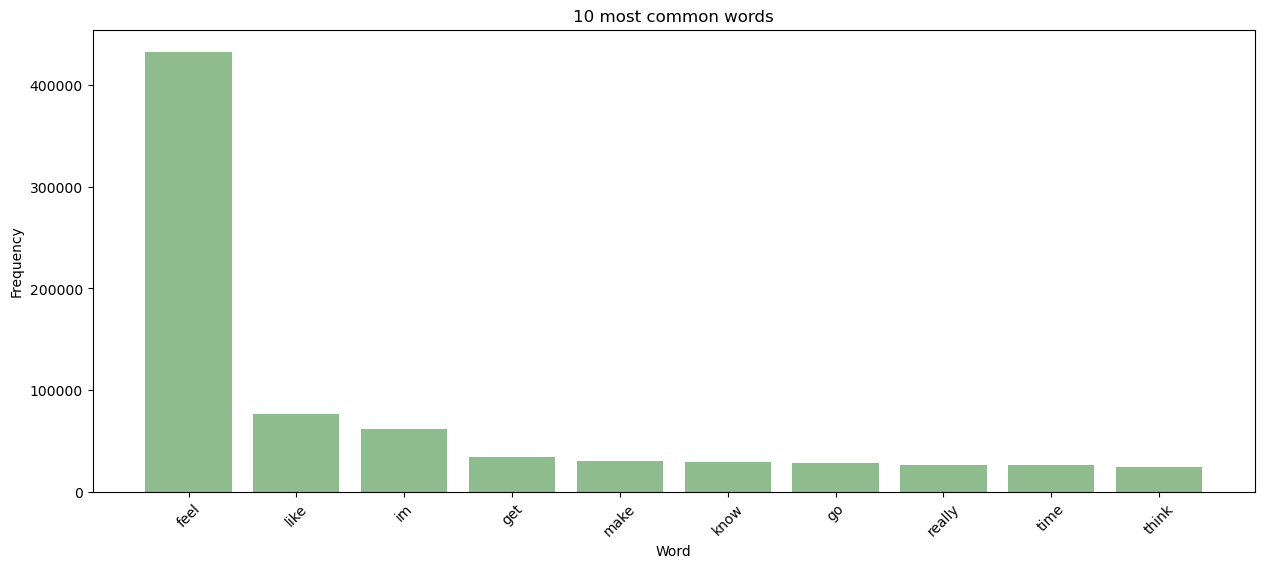

In [21]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

new_df_samlet = df_samlet.copy()

def process_text(text):
    tokenized_text = re.findall(r'\b\w+\b', text)
    new_text = [word for word in tokenized_text if word.lower() not in stop_words]
    lemmatized_text = [lemmatizer.lemmatize(word, pos = 'v') for word in new_text]
    return ' '.join(lemmatized_text)

new_df_samlet['text'] = new_df_samlet['text'].apply(process_text)



new_df_samlet = new_df_samlet.drop('word_freq', axis=1)


def word_freq(text):
    # Find words and count their frequencies
    words = re.findall(r'\b\w+\b', text)
    word_counts = Counter(words)

    return word_counts

new_df_samlet['word_freq'] = new_df_samlet['text'].apply(word_freq)

all_word_counts = Counter()

for freq in new_df_samlet['word_freq']:
    all_word_counts.update(freq)

most_common_words = all_word_counts.most_common(10)
words = [word for word, _ in most_common_words]
freqs = [count for _, count in most_common_words]


plt.figure(figsize=(15, 6))
plt.bar(words, freqs, color='darkseagreen')
plt.title('10 most common words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Word frequencies after lemmatization in outliers

                                                  text  label label_name  \
40   feel doubtful place world technology applicabl...      4       fear   
69   actually think fairly authentic person general...      0    sadness   
101  try dismissive elections since feel privileged...      1        joy   
218  feel really boring end playing good vs good ma...      0    sadness   
289  forgive accepting allowing created energy high...      2       love   

     text_length                                          word_freq  
40           292  {'i': 3, 'feel': 1, 'doubtful': 1, 'about': 2,...  
69           265  {'i': 4, 'actually': 1, 'think': 1, 'am': 2, '...  
101          243  {'i': 2, 'try': 1, 'not': 1, 'to': 4, 'be': 2,...  
218          275  {'i': 3, 'feel': 1, 'it': 3, 's': 2, 'just': 1...  
289          269  {'i': 1, 'forgive': 1, 'myself': 2, 'for': 2, ...  


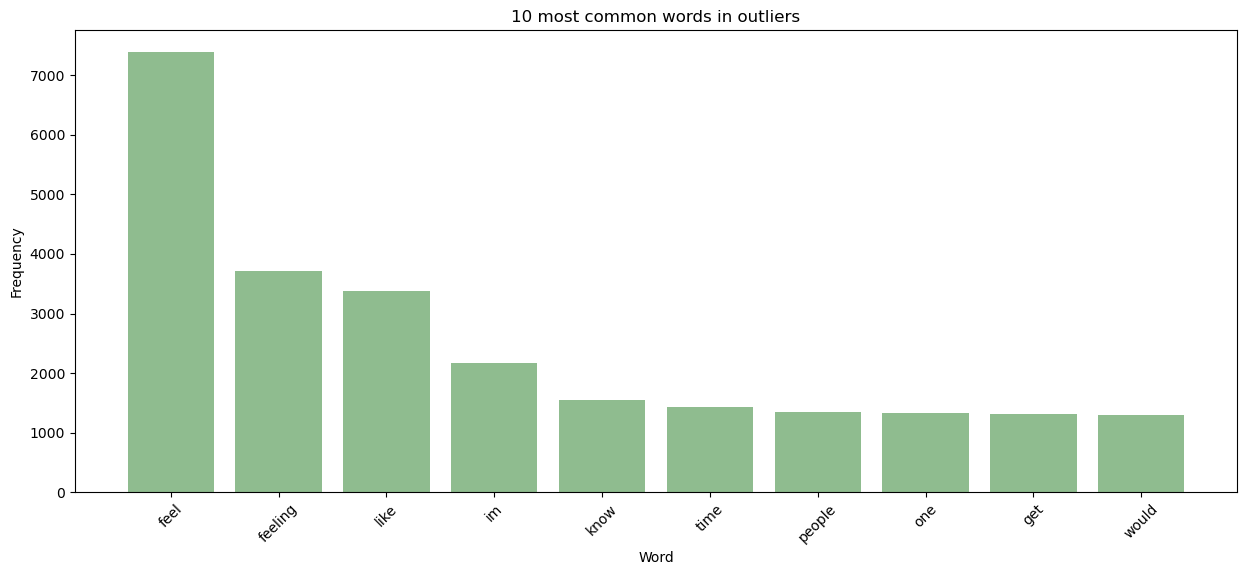

In [210]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

new_outliers = outliers.copy()

def process_text(text):
    lemmatized_text = lemmatizer.lemmatize(text)
    tokenized_text = re.findall(r'\b\w+\b', lemmatized_text)
    new_text = [word for word in tokenized_text if word.lower() not in stop_words]
    return ' '.join(new_text)

new_outliers['text'] = new_outliers['text'].apply(process_text)

print(new_outliers.head())


new_outliers = new_outliers.drop('word_freq', axis=1)


def word_freq(text):
    # Find words and count their frequencies
    words = re.findall(r'\b\w+\b', text)
    word_counts = Counter(words)

    return word_counts

new_outliers['word_freq'] = new_outliers['text'].apply(word_freq)

all_word_counts = Counter()

for freq in new_outliers['word_freq']:
    all_word_counts.update(freq)

most_common_words_outliers = all_word_counts.most_common(10)
words = [word for word, _ in most_common_words_outliers]
freqs = [count for _, count in most_common_words_outliers]


plt.figure(figsize=(15, 6))
plt.bar(words, freqs, color='darkseagreen')
plt.title('10 most common words in outliers')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()